In [1]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat.shape)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat.shape)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star.shape)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.6)
print("tcp_star_targets shape:", tcp_star_targets.shape)

['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)
predicted class : (5702,)
predicted probabilities : (5702,)
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : (5702,)
true class labels : [ 8 11 11 ... 11  9  1]
tcp_star_targets shape: (5702,)


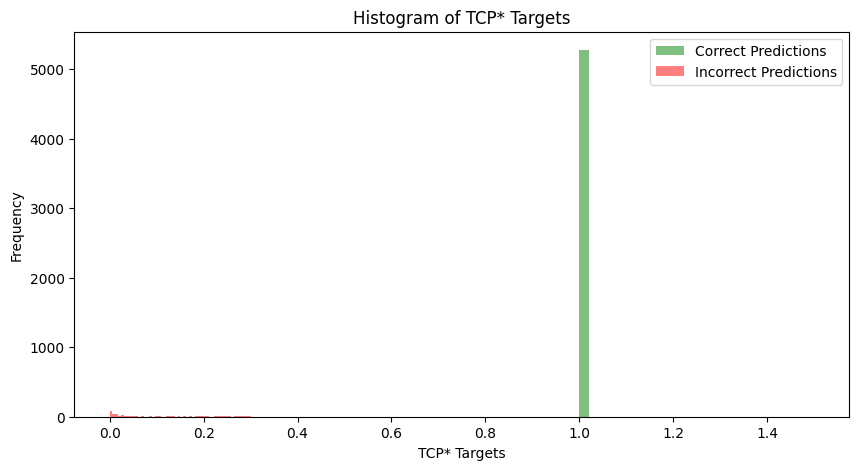

In [4]:
#plot histogram of tcp_star_targets differentiating between correct and incorrect predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(tcp_star_targets[y_true_class == y_hat], bins=50, alpha=
0.5, label='Correct Predictions', color='green')
plt.hist(tcp_star_targets[y_true_class != y_hat], bins=50, alpha=0.5, label='Incorrect Predictions', color='red')
plt.xlabel('TCP* Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP* Targets')
plt.legend()
plt.show()

In [5]:
successful_predictions = tcp_star_targets[y_true_class == y_hat]
print("Successful predictions (TCP* targets):", successful_predictions)
print("Number of successful predictions:", len(successful_predictions))
unsuccessful_predictions = tcp_star_targets[y_true_class != y_hat]
print("Unsuccessful predictions (TCP* targets):", unsuccessful_predictions)
print("Number of unsuccessful predictions:", len(unsuccessful_predictions))

Successful predictions (TCP* targets): [1. 1. 1. ... 1. 1. 1.]
Number of successful predictions: 5276
Unsuccessful predictions (TCP* targets): [2.73557784e-01 1.49783741e-01 5.72949244e-02 3.24206739e-03
 1.08138802e-01 1.92251038e-01 8.84338883e-02 1.24157077e-02
 1.89669913e-01 1.82783182e-01 1.71918786e-03 1.56670949e-02
 1.05978023e-02 7.00991555e-03 4.00187373e-02 1.75796918e-02
 5.27239739e-02 2.73317947e-01 1.30098008e-02 2.03093457e-01
 4.80290432e-02 6.31175274e-03 2.85611898e-01 4.27138537e-02
 2.57537797e-01 1.56805907e-03 2.80410363e-01 2.81416091e-03
 1.29407819e-03 4.39231183e-02 8.08889251e-03 1.17626168e-01
 5.35545805e-03 1.44211517e-03 1.30517977e-02 6.18956047e-04
 2.36256855e-01 1.46645177e-01 2.05928794e-01 2.44380473e-01
 7.93820331e-03 1.83728896e-02 7.23630525e-03 1.23206698e-01
 2.72372550e-03 3.01307442e-01 1.21487199e-01 1.08409800e-01
 1.68268119e-02 1.98359942e-01 6.31701228e-02 8.54373419e-02
 1.40199018e-01 1.24145705e-02 2.14724065e-01 5.47877564e-02
 5.

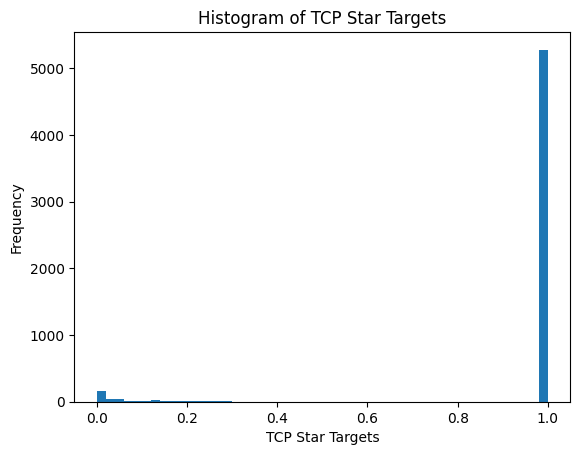

In [3]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [205]:
print(tcp_star_targets[y_hat==y_true_class].mean(),
      tcp_star_targets[y_hat!=y_true_class].mean())

1.0 0.08851985832763194


In [206]:
from sklearn.model_selection import train_test_split

X= embeddings
y = tcp_star_targets
from sklearn.model_selection import train_test_split

all_indices = np.arange(len(embeddings))  
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Now use these to split all your arrays
X_train = embeddings[train_indices]
y_train = tcp_star_targets[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_star_targets[test_indices]

# Also for classifier outputs
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]

In [207]:
class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU(),
        )
        self.validity_head = nn.Linear(128,1)
        self.tcp_head = nn.Sequential(nn.Linear(128,64),
                                      nn.ReLU(),
                                      nn.Linear(64,1),
                                      nn.Sigmoid())              
    def forward(self,x):
        feat = self.shared(x)
        validity_logit = self.validity_head(feat).squeeze(-1)
        tcp_pred = self.tcp_head(feat).squeeze(-1)
        return validity_logit, tcp_pred
        #return self.validity_head(feat).squeeze(-1), self.tcp_head(feat).squeeze(-1)

In [208]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Prepare training sets
is_correct_train = (y_hat_train == y_true_class_train)

X_train_errors = X_train_tensor[~is_correct_train]
y_train_errors = tcp_star_targets[train_indices][~is_correct_train]

X_train_success = X_train_tensor[is_correct_train]
y_train_success = tcp_star_targets[train_indices][is_correct_train]
# Make sure y_train_success is a tensor
y_train_success = torch.tensor(y_train_success, dtype=torch.float32)
y_train_errors = torch.tensor(y_train_errors, dtype=torch.float32)

# Do the same for X errors/successes if not already
X_train_success = torch.tensor(X_train_success, dtype=torch.float32)
X_train_errors = torch.tensor(X_train_errors, dtype=torch.float32)

print(f"Errors in train: {len(X_train_errors)}, Successes in train: {len(X_train_success)}")

Errors in train: 342, Successes in train: 4219


/var/folders/d4/bgr0tr5d43z2xmtq5hk3s4n00000gn/T/ipykernel_19863/516042292.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_success = torch.tensor(X_train_success, dtype=torch.float32)
/var/folders/d4/bgr0tr5d43z2xmtq5hk3s4n00000gn/T/ipykernel_19863/516042292.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_errors = torch.tensor(X_train_errors, dtype=torch.float32)


In [209]:
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset= TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

error_batch_size = 64
success_batch_size = 64
num_epochs = 60
num_success_batches = len(X_train_success) // success_batch_size
num_error_batches = len(X_train_errors) // error_batch_size

print(f"Number of success batches: {num_success_batches}, Number of error batches: {num_error_batches}")

Number of success batches: 65, Number of error batches: 5


In [210]:
bce_loss = nn.BCEWithLogitsLoss()
mse_loss= nn.MSELoss()

In [211]:
input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Freeze TCPR head
for param in model.tcp_head.parameters():
    param.requires_grad = False

bce_loss = nn.BCEWithLogitsLoss()

for epoch in range(60):
    model.train()
    train_losses = []

    for i in range(num_success_batches):
        err_idx = i % num_error_batches

        X_batch = torch.cat([success_chunks_X[i], error_chunks_X[err_idx]])
        validity_target = torch.cat([
            torch.ones(len(success_chunks_X[i]), device=X_batch.device),
            torch.zeros(len(error_chunks_X[err_idx]), device=X_batch.device)
        ])

        validity_logits, _ = model(X_batch)
        loss = bce_loss(validity_logits, validity_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"[Pretrain Validity] Epoch {epoch+1} | Loss: {sum(train_losses)/len(train_losses):.6f}")
for param in model.tcp_head.parameters():
    param.requires_grad = True

for epoch in range(num_epochs):
     model.train()
     train_losses = []

     # Shuffle successes and errors
     perm_success = torch.randperm(len(X_train_success))
     perm_errors = torch.randperm(len(X_train_errors))

     X_success_shuffled = X_train_success[perm_success]
     y_success_shuffled = y_train_success[perm_success]
     X_errors_shuffled = X_train_errors[perm_errors]
     y_errors_shuffled = y_train_errors[perm_errors]

    # Split into chunks
     success_chunks_X = X_success_shuffled.split(success_batch_size)
     success_chunks_y = y_success_shuffled.split(success_batch_size)
     error_chunks_X = list(X_errors_shuffled.split(error_batch_size))
     error_chunks_y = list(y_errors_shuffled.split(error_batch_size))

     # Iterate over success batches
     for i in range(num_success_batches):
         err_idx = i % num_error_batches

         X_batch = torch.cat([success_chunks_X[i], error_chunks_X[err_idx]])
         y_batch = torch.cat([success_chunks_y[i], error_chunks_y[err_idx]])
         print(
            f"Epoch {epoch+1}/{num_epochs} | success_chunk={i}/{num_success_batches-1} "
            f"| error_chunk={err_idx}/{num_error_batches-1}"
         )
         validity_logits, tcp_pred = model(X_batch)


         loss_validity = bce_loss(validity_logits, validity_target)
         success_mask = (validity_target == 1)
         error_mask = (validity_target == 0)

        # For successes: log loss (encourage TCPR ~ 1)
         log_loss = -torch.log(tcp_pred[success_mask] + 1e-8).mean()
         mse_loss_ = F.mse_loss(tcp_pred[error_mask], y_batch[error_mask])
         loss = loss_validity + log_loss + 5.0 * mse_loss_


#         validity_target = torch.cat([
#             torch.ones(len(success_chunks_X[i]), device=X_batch.device),
#             torch.zeros(len(error_chunks_X[err_idx]), device=X_batch.device),
#         ])

#         _, tcpr_pred = model(X_batch)
#         log_loss=-torch.log((tcpr_pred[validity_target == 1] + 1e-8)** 2).mean()
#         mse_loss_ = F.mse_loss(tcpr_pred[validity_target == 0], y_batch[validity_target == 0])
#         loss = log_loss + 5.0 * mse_loss_

         optimizer.zero_grad()
         loss.backward()
         optimizer.step()

         train_losses.append(loss.item())

     avg_train_loss = sum(train_losses) / len(train_losses)
     print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f}")

    # # Validation
    # model.eval()
    # val_losses = []
    # with torch.no_grad():
    #     val_validity_logits, val_tcpr_pred = model(X_val_tensor)

    #     val_validity_target = torch.tensor(
    #         (y_hat[test_indices] == y_true_class[test_indices]),
    #         dtype=torch.float32
    #     )
    #     val_success_mask = (val_validity_target == 1)
    #     val_error_mask = (val_validity_target == 0)

    #     val_log_loss = -torch.log((val_tcpr_pred[val_success_mask] + 1e-8)** 2).mean()
    #     val_mse_loss_error = F.mse_loss(
    #         val_tcpr_pred[val_error_mask],
    #         y_val_tensor[val_error_mask]
    #     )
    #     val_loss = val_log_loss + 5.0 * val_mse_loss_error
    #     val_losses.append(val_loss.item())
    # avg_val_loss = sum(val_losses) / len(val_losses)
    # print(f"Epoch {epoch+1:02d} | Validation Loss: {avg_val_loss:.6f}")

[Pretrain Validity] Epoch 1 | Loss: 0.545419
[Pretrain Validity] Epoch 2 | Loss: 0.437036
[Pretrain Validity] Epoch 3 | Loss: 0.393054
[Pretrain Validity] Epoch 4 | Loss: 0.363427
[Pretrain Validity] Epoch 5 | Loss: 0.340270
[Pretrain Validity] Epoch 6 | Loss: 0.320689
[Pretrain Validity] Epoch 7 | Loss: 0.303911
[Pretrain Validity] Epoch 8 | Loss: 0.288623
[Pretrain Validity] Epoch 9 | Loss: 0.274150
[Pretrain Validity] Epoch 10 | Loss: 0.261555
[Pretrain Validity] Epoch 11 | Loss: 0.248977
[Pretrain Validity] Epoch 12 | Loss: 0.236570
[Pretrain Validity] Epoch 13 | Loss: 0.224833
[Pretrain Validity] Epoch 14 | Loss: 0.213539
[Pretrain Validity] Epoch 15 | Loss: 0.203657
[Pretrain Validity] Epoch 16 | Loss: 0.194556
[Pretrain Validity] Epoch 17 | Loss: 0.186430
[Pretrain Validity] Epoch 18 | Loss: 0.179967
[Pretrain Validity] Epoch 19 | Loss: 0.172115
[Pretrain Validity] Epoch 20 | Loss: 0.166830
[Pretrain Validity] Epoch 21 | Loss: 0.159108
[Pretrain Validity] Epoch 22 | Loss: 0.1532

In [214]:
model.eval()
val_losses = []
with torch.no_grad():
    val_validity_logits, val_tcpr_pred = model(X_val_tensor)

    # Build ground-truth validity target
    val_validity_target = torch.tensor(
        (y_hat[test_indices] == y_true_class[test_indices]),
        dtype=torch.float32,
        device=X_val_tensor.device
    )

    # --- 1. Validity Head Loss ---
    loss_validity = bce_loss(val_validity_logits, val_validity_target)

    # --- 2. TCPR Loss ---
    success_mask = (val_validity_target == 1)
    error_mask = (val_validity_target == 0)

    # Log-loss for correct predictions
    log_loss = -torch.log(val_tcpr_pred[success_mask] + 1e-8).mean() if success_mask.any() else 0.0

    # MSE-to-zero for incorrect predictions
    mse_error = mse_loss(
        val_tcpr_pred[error_mask],
        torch.zeros_like(val_tcpr_pred[error_mask])
    ) if error_mask.any() else 0.0

    # Final validation loss
    val_loss = loss_validity + 5.0 * (log_loss + mse_error)
    val_losses.append(val_loss.item())

avg_val_loss = sum(val_losses) / len(val_losses)
print(f"[Validation] Epoch {epoch+1:02d} | Validation Loss: {avg_val_loss:.6f}")

[Validation] Epoch 60 | Validation Loss: 4.974096


In [215]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(embeddings, dtype=torch.float32)
    _, confidence_scores_tcpr = model(Xall_tensor)
    confidence_scores_tcpr = confidence_scores_tcpr.cpu().numpy()  # shape: (num_samples,)

In [216]:
confidence_scores_tcpr

array([0.19854905, 1.        , 0.11527275, ..., 1.        , 1.        ,
       0.9912186 ], dtype=float32)

In [6]:
import matplotlib.pyplot as plt

is_correct_full = (y_hat == y_true_class)
success_conf = confidence_scores_tcpr[is_correct_full]
error_conf = confidence_scores_tcpr[~is_correct_full]

plt.figure(figsize=(8, 5))
plt.hist(success_conf, bins=50, density=True, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=50, density=True, alpha=0.7, label='Error', color='red')
plt.xlabel('TCP*R Confidence')
plt.ylabel('Density')
plt.title('TCP*R Confidence Density: Success vs Error')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'confidence_scores_tcpr' is not defined

In [218]:
def compute_ECE(confidences, predictions, labels, n_bins=15):
    """
    Compute Expected Calibration Error (ECE).

    confidences: np.array of predicted confidence scores (0 to 1)
    predictions: np.array of predicted classes
    labels: np.array of true classes
    n_bins: number of bins
    """
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            accuracy_in_bin = np.mean(accuracies[in_bin])
            bin_gap = abs(avg_confidence_in_bin - accuracy_in_bin)

            ece += prop_in_bin * bin_gap

    return ece



# Compute ECE for TCP*R confidence scores
ece_tcpr = compute_ECE(confidence_scores_tcpr, y_hat, y_true_class, n_bins=15)
print(f"ECE for TCP*R confidence scores: {ece_tcpr:.4f}")

ECE for TCP*R confidence scores: 0.0245


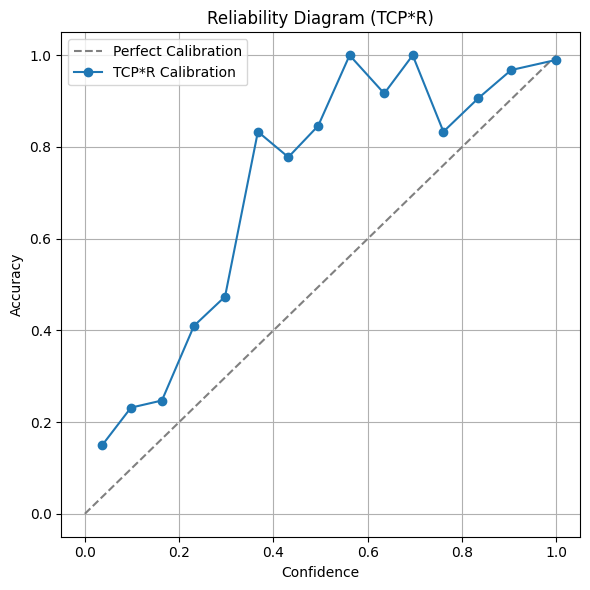

In [219]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    bin_confidences = []
    bin_accuracies = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        if np.sum(in_bin) > 0:
            bin_confidences.append(np.mean(confidences[in_bin]))
            bin_accuracies.append(np.mean(accuracies[in_bin]))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.plot(bin_confidences, bin_accuracies, marker='o', label='TCP*R Calibration')

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram (TCP*R)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_reliability_diagram(confidence_scores_tcpr, y_hat, y_true_class)

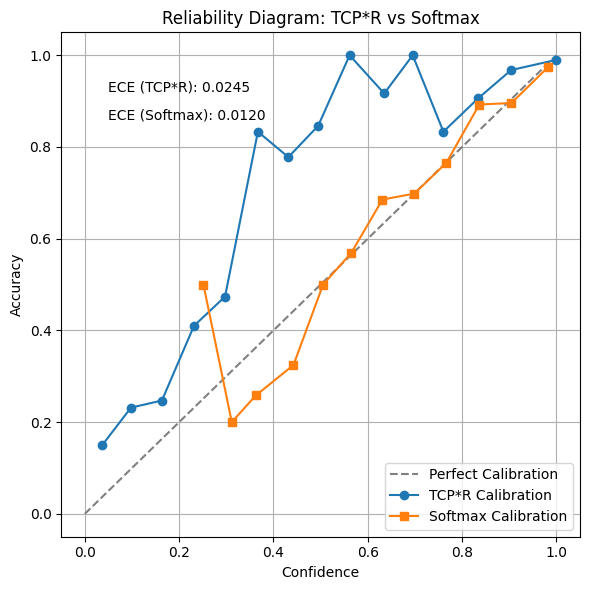

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def reliability_curve(confidences, predictions, labels, n_bins=15):
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    accuracies = (predictions == labels)
    bin_centers = []
    bin_accs = []
    bin_confs = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        if np.any(in_bin):
            bin_conf = np.mean(confidences[in_bin])
            bin_acc = np.mean(accuracies[in_bin])
            bin_centers.append(bin_conf)
            bin_accs.append(bin_acc)

    return bin_centers, bin_accs

# Compute both sets of reliability data
tcp_centers, tcp_accs = reliability_curve(confidence_scores_tcpr, y_hat, y_true_class)
softmax_centers, softmax_accs = reliability_curve(p_y_hat, y_hat, y_true_class)

# Plot
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.plot(tcp_centers, tcp_accs, marker='o', label='TCP*R Calibration')
plt.plot(softmax_centers, softmax_accs, marker='s', label='Softmax Calibration')
ece_tcp = compute_ECE(confidence_scores_tcpr, y_hat, y_true_class)
ece_softmax = compute_ECE(p_y_hat, y_hat, y_true_class)

plt.text(0.05, 0.92, f"ECE (TCP*R): {ece_tcp:.4f}", fontsize=10)
plt.text(0.05, 0.86, f"ECE (Softmax): {ece_softmax:.4f}", fontsize=10)
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram: TCP*R vs Softmax')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()